In [4]:
from pathlib import Path
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    PROJECT_ROOT = Path("/content/drive/MyDrive/ABT_Global/AI-Studio-Project")
except ImportError:
    PROJECT_ROOT = Path("../..").resolve()
PROCESSED = PROJECT_ROOT / "data" / "processed"
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
print(f"Data: {PROCESSED}")
print(f"Models: {MODELS_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data: /content/drive/MyDrive/ABT_Global/AI-Studio-Project/data/processed
Models: /content/drive/MyDrive/ABT_Global/AI-Studio-Project/models


## Environment Setup

# Hyperparameter Tuning for Gradient Boosting
# This notebook performs hyperparameter optimization using Random Search CV and compares results with ANOVA analysis.

In [2]:
import os
print(os.getcwd())

/content


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the stratified splits using dynamic paths
try:
    train_df = pd.read_csv(PROCESSED / "train_df.csv")
    val_df = pd.read_csv(PROCESSED / "val_df.csv")
    test_df = pd.read_csv(PROCESSED / "test_df.csv")
    print("Successfully loaded stratified splits")
except FileNotFoundError:
    print("Split files not found. Please run the data splitting code first.")
    raise

print("Dataset shapes:")
print(f"   Training: {train_df.shape}")
print(f"   Validation: {val_df.shape}")
print(f"   Test: {test_df.shape}")

Successfully loaded stratified splits
Dataset shapes:
   Training: (2385681, 24)
   Validation: (795227, 24)
   Test: (795227, 24)


In [8]:
# %%
# Prepare features and target
def prepare_features_targets(train_df, val_df, test_df):
    """Prepare features and targets for modeling using target encoding for high-cardinality categoricals"""

    # Columns to exclude (metadata and target)
    exclude_cols = ['outage_occurred', 'date', 'fips_code', 'month']

    # High cardinality categorical columns for target encoding
    target_encode_cols = ['county', 'state']

    # Target Encoding (Mean Encoding) for high-cardinality features
    # Calculate mappings only on training data to avoid data leakage
    global_mean_outage = train_df['outage_occurred'].mean()
    encoded_train_dfs = [train_df.copy(), val_df.copy(), test_df.copy()]

    print(f"Applying Target Encoding for: {target_encode_cols}")
    for col in target_encode_cols:
        # Calculate mapping from training data
        mapping = train_df.groupby(col)['outage_occurred'].mean().to_dict()

        # Apply mapping to all datasets
        encoded_train_dfs[0][f'{col}_encoded_target'] = encoded_train_dfs[0][col].map(mapping).fillna(global_mean_outage)
        encoded_train_dfs[1][f'{col}_encoded_target'] = encoded_train_dfs[1][col].map(mapping).fillna(global_mean_outage)
        encoded_train_dfs[2][f'{col}_encoded_target'] = encoded_train_dfs[2][col].map(mapping).fillna(global_mean_outage)

        # Add original columns to exclude list after encoding
        exclude_cols.append(col)

    train_df_processed, val_df_processed, test_df_processed = encoded_train_dfs

    # Get feature columns (only those present in all datasets after target encoding)
    common_cols = list(set(train_df_processed.columns) & set(val_df_processed.columns) & set(test_df_processed.columns))
    feature_cols = [col for col in common_cols if col not in exclude_cols]

    # Identify other categorical columns that still need one-hot encoding
    # These should exclude the ones we just target encoded
    one_hot_encode_cols = [col for col in feature_cols if (train_df_processed[col].dtype == 'object' or train_df_processed[col].dtype == 'category') and col not in target_encode_cols]

    print(f"Using {len(feature_cols)} initial features (including target-encoded), {len(one_hot_encode_cols)} of which are categorical for one-hot encoding.")
    print(f"One-Hot Encoding for: {one_hot_encode_cols}")

    # Apply one-hot encoding to remaining categorical features
    train_df_encoded = pd.get_dummies(train_df_processed, columns=one_hot_encode_cols, drop_first=True)
    val_df_encoded = pd.get_dummies(val_df_processed, columns=one_hot_encode_cols, drop_first=True)
    test_df_encoded = pd.get_dummies(test_df_processed, columns=one_hot_encode_cols, drop_first=True)

    # Align columns - crucial for consistent feature sets after one-hot encoding
    # Get all columns from training set after encoding
    final_feature_cols = [col for col in train_df_encoded.columns if col not in exclude_cols]

    # Reindex validation and test sets to match training set columns, filling missing with 0
    X_train = train_df_encoded[final_feature_cols]
    X_val = val_df_encoded.reindex(columns=final_feature_cols, fill_value=0)
    X_test = test_df_encoded.reindex(columns=final_feature_cols, fill_value=0)

    y_train = train_df_encoded['outage_occurred']
    y_val = val_df_encoded['outage_occurred']
    y_test = test_df_encoded['outage_occurred']

    print(f"Using {len(final_feature_cols)} features after all encoding steps.")
    for i, col in enumerate(final_feature_cols[:10]):  # Show first 10 features
        print(f"  {i+1}. {col}")
    if len(final_feature_cols) > 10:
        print(f"  ... and {len(final_feature_cols) - 10} more features")

    return X_train, X_val, X_test, y_train, y_val, y_test, final_feature_cols

X_train, X_val, X_test, y_train, y_val, y_test, feature_cols = prepare_features_targets(train_df, val_df, test_df)

# Check class distribution
print("Class distribution in each set:")
print(f"Training - Outages: {y_train.sum():,} ({y_train.mean():.3%})")
print(f"Validation - Outages: {y_val.sum():,} ({y_val.mean():.3%})")
print(f"Test - Outages: {y_test.sum():,} ({y_test.mean():.3%})")

Applying Target Encoding for: ['county', 'state']
Using 20 initial features (including target-encoded), 0 of which are categorical for one-hot encoding.
One-Hot Encoding for: []
Using 20 features after all encoding steps.
  1. is_weekend
  2. day_of_week_sin
  3. state_encoded
  4. day_of_year_cos
  5. tmax
  6. region_encoded
  7. extreme_cold
  8. temp_range
  9. temp_stress
  10. extreme_hot
  ... and 10 more features
Class distribution in each set:
Training - Outages: 1,104,111 (46.281%)
Validation - Outages: 368,036 (46.281%)
Test - Outages: 368,037 (46.281%)


In [9]:
# %%
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [10]:
# %%
# Define hyperparameter search space
param_dist = {
    'n_estimators': [50, 100, 150, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [20, 50, 100, 200],
    'min_samples_leaf': [10, 20, 50, 100],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

print("Hyperparameter search space:")
for param, values in param_dist.items():
    print(f"  {param}: {values}")

Hyperparameter search space:
  n_estimators: [50, 100, 150, 200, 300]
  learning_rate: [0.01, 0.05, 0.1, 0.2, 0.3]
  max_depth: [3, 4, 5, 6, 7]
  min_samples_split: [20, 50, 100, 200]
  min_samples_leaf: [10, 20, 50, 100]
  subsample: [0.6, 0.7, 0.8, 0.9, 1.0]
  max_features: ['sqrt', 'log2', None]


In [11]:
# %%
# Create custom scorers focusing on recall and F1
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

In [12]:
# %%
# Perform Random Search with cross-validation
print("Starting Random Search CV...")

# Use F1 as primary scoring since we care about balance between recall and precision
gb_base = GradientBoostingClassifier(random_state=RANDOM_STATE, verbose=0)

random_search = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=param_dist,
    n_iter=5,  # Number of parameter combinations to try
    cv=3,       # 3-fold cross-validation
    scoring='f1',  # Primary metric
    refit=True,
    n_jobs=-1,  # Use all available cores
    random_state=RANDOM_STATE,
    verbose=1
)

# Fit on combined train+val for more data
X_train_val = np.vstack([X_train_scaled, X_val_scaled])
y_train_val = np.concatenate([y_train, y_val])

random_search.fit(X_train_val, y_train_val)

print("Random Search completed!")

Starting Random Search CV...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Search completed!


In [ ]:
# %%
# Display best parameters and scores
print("\n" + "="*70)
print("RANDOM SEARCH RESULTS")
print("="*70)
print(f"Best F1 Score (CV): {random_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

In [14]:
# %%
# Evaluate best model on test set
best_model = random_search.best_estimator_

# Make predictions
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"\nTest Set Performance of Best Model:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")
print(f"  ROC-AUC:   {test_roc_auc:.4f}")


Test Set Performance of Best Model:
  Accuracy:  0.7340
  Recall:    0.7134
  Precision: 0.7123
  F1-Score:  0.7129
  ROC-AUC:   0.8115


In [15]:
# %%
# Compare with original model
def load_original_model():
    """Load the original gradient boosting model for comparison"""
    try:
        model_path = Path("/content/drive/MyDrive/Abt_Global/AI-Studio-Project/models/gradient_boosting/gradient_boosting_model.pkl")
        if model_path.exists():
            original_model = joblib.load(model_path)
            return original_model
    except:
        pass
    return None

original_model = load_original_model()

if original_model:
    y_test_pred_orig = original_model.predict(X_test_scaled)
    y_test_proba_orig = original_model.predict_proba(X_test_scaled)[:, 1]

    orig_accuracy = accuracy_score(y_test, y_test_pred_orig)
    orig_recall = recall_score(y_test, y_test_pred_orig)
    orig_precision = precision_score(y_test, y_test_pred_orig)
    orig_f1 = f1_score(y_test, y_test_pred_orig)
    orig_roc_auc = roc_auc_score(y_test, y_test_proba_orig)

    print("\n" + "="*70)
    print("MODEL COMPARISON: TUNED vs ORIGINAL")
    print("="*70)
    print(f"{'Metric':<12} {'Original':<10} {'Tuned':<10} {'Improvement':<12}")
    print(f"{'-'*70}")
    print(f"{'Accuracy':<12} {orig_accuracy:.4f}     {test_accuracy:.4f}     {test_accuracy - orig_accuracy:+.4f}")
    print(f"{'Recall':<12} {orig_recall:.4f}     {test_recall:.4f}     {test_recall - orig_recall:+.4f}")
    print(f"{'Precision':<12} {orig_precision:.4f}     {test_precision:.4f}     {test_precision - orig_precision:+.4f}")
    print(f"{'F1-Score':<12} {orig_f1:.4f}     {test_f1:.4f}     {test_f1 - orig_f1:+.4f}")
    print(f"{'ROC-AUC':<12} {orig_roc_auc:.4f}     {test_roc_auc:.4f}     {test_roc_auc - orig_roc_auc:+.4f}")

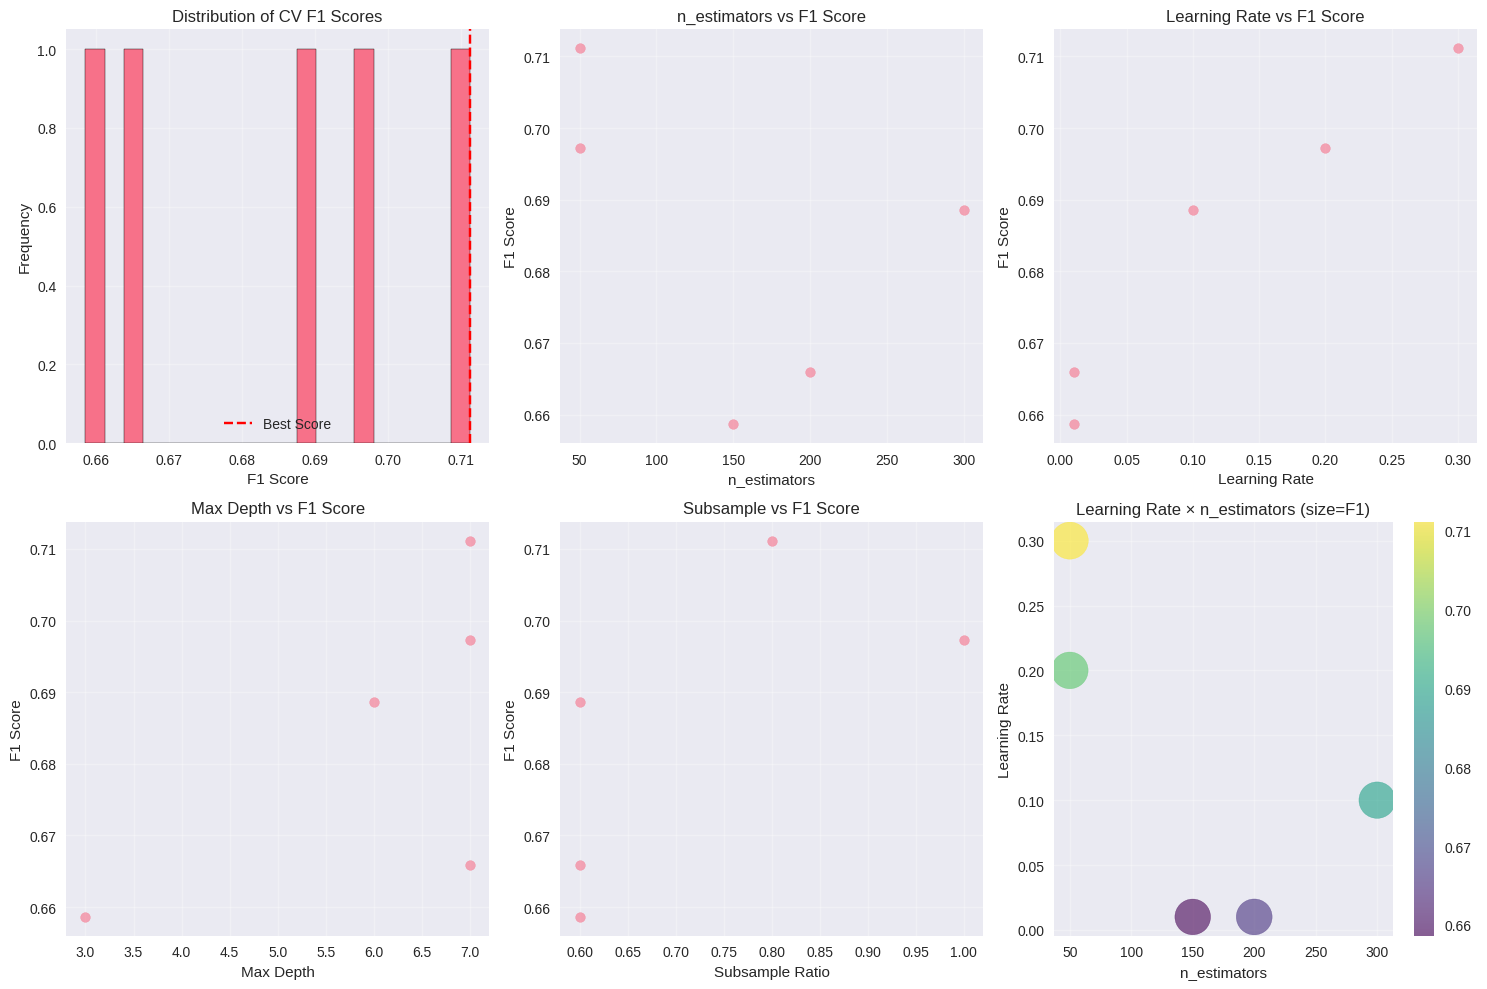

In [16]:
# %%
# Visualize hyperparameter effects
def plot_hyperparameter_effects(cv_results):
    """Create visualizations of hyperparameter effects"""

    results_df = pd.DataFrame(cv_results)

    # Plot 1: Score distribution
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    # 1. F1 Score distribution
    axes[0].hist(results_df['mean_test_score'], bins=20, edgecolor='black')
    axes[0].axvline(x=results_df['mean_test_score'].max(), color='red', linestyle='--', label='Best Score')
    axes[0].set_xlabel('F1 Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of CV F1 Scores')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. N estimators vs F1
    axes[1].scatter(results_df['param_n_estimators'], results_df['mean_test_score'], alpha=0.6)
    axes[1].set_xlabel('n_estimators')
    axes[1].set_ylabel('F1 Score')
    axes[1].set_title('n_estimators vs F1 Score')
    axes[1].grid(True, alpha=0.3)

    # 3. Learning rate vs F1
    axes[2].scatter(results_df['param_learning_rate'], results_df['mean_test_score'], alpha=0.6)
    axes[2].set_xlabel('Learning Rate')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_title('Learning Rate vs F1 Score')
    axes[2].grid(True, alpha=0.3)

    # 4. Max depth vs F1
    axes[3].scatter(results_df['param_max_depth'], results_df['mean_test_score'], alpha=0.6)
    axes[3].set_xlabel('Max Depth')
    axes[3].set_ylabel('F1 Score')
    axes[3].set_title('Max Depth vs F1 Score')
    axes[3].grid(True, alpha=0.3)

    # 5. Subsample vs F1
    axes[4].scatter(results_df['param_subsample'], results_df['mean_test_score'], alpha=0.6)
    axes[4].set_xlabel('Subsample Ratio')
    axes[4].set_ylabel('F1 Score')
    axes[4].set_title('Subsample vs F1 Score')
    axes[4].grid(True, alpha=0.3)

    # 6. Learning rate vs n_estimators (bubble chart)
    scatter = axes[5].scatter(
        results_df['param_n_estimators'],
        results_df['param_learning_rate'],
        s=results_df['mean_test_score']*1000,
        c=results_df['mean_test_score'],
        alpha=0.6,
        cmap='viridis'
    )
    axes[5].set_xlabel('n_estimators')
    axes[5].set_ylabel('Learning Rate')
    axes[5].set_title('Learning Rate × n_estimators (size=F1)')
    plt.colorbar(scatter, ax=axes[5])
    axes[5].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results_df

# Plot hyperparameter effects
cv_results_df = plot_hyperparameter_effects(random_search.cv_results_)

In [17]:
# %%
# ANOVA Analysis: Statistical comparison of hyperparameter effects
def perform_anova_analysis(cv_results_df):
    """Perform ANOVA to analyze statistical significance of hyperparameter effects"""

    print("\n" + "="*70)
    print("ANOVA ANALYSIS OF HYPERPARAMETER EFFECTS")
    print("="*70)

    # Prepare data for ANOVA
    anova_data = []

    for param in ['param_n_estimators', 'param_learning_rate', 'param_max_depth',
                  'param_min_samples_split', 'param_min_samples_leaf', 'param_subsample']:

        if param in cv_results_df.columns:
            param_values = cv_results_df[param].astype(str)
            scores = cv_results_df['mean_test_score']

            # Group scores by parameter value
            groups = {}
            for value, score in zip(param_values, scores):
                if value not in groups:
                    groups[value] = []
                groups[value].append(score)

            # Perform one-way ANOVA
            group_lists = [groups[val] for val in groups]
            if len(group_lists) > 1:
                f_stat, p_value = stats.f_oneway(*group_lists)

                param_name = param.replace('param_', '')
                print(f"\n{param_name.upper()}:")
                print(f"  F-statistic: {f_stat:.4f}")
                print(f"  p-value:     {p_value:.6f}")

                if p_value < 0.05:
                    print(f"  → Statistically significant (p < 0.05)")
                else:
                    print(f"  → Not statistically significant")

                # Calculate effect size (η²)
                ss_between = sum([len(g) * (np.mean(g) - np.mean(scores))**2 for g in group_lists])
                ss_total = sum([(x - np.mean(scores))**2 for x in scores])
                eta_squared = ss_between / ss_total
                print(f"  Effect size (η²): {eta_squared:.4f}")

                anova_data.append({
                    'parameter': param_name,
                    'f_statistic': f_stat,
                    'p_value': p_value,
                    'eta_squared': eta_squared,
                    'significant': p_value < 0.05
                })

    return pd.DataFrame(anova_data)

# Perform ANOVA
anova_results = perform_anova_analysis(cv_results_df)


ANOVA ANALYSIS OF HYPERPARAMETER EFFECTS

N_ESTIMATORS:
  F-statistic: 6.2368
  p-value:     0.284346
  → Not statistically significant
  Effect size (η²): 0.9493

LEARNING_RATE:
  F-statistic: 23.4711
  p-value:     0.150315
  → Not statistically significant
  Effect size (η²): 0.9860

MAX_DEPTH:
  F-statistic: 0.7740
  p-value:     0.563712
  → Not statistically significant
  Effect size (η²): 0.4363

MIN_SAMPLES_SPLIT:
  F-statistic: 0.8988
  p-value:     0.526647
  → Not statistically significant
  Effect size (η²): 0.4734

MIN_SAMPLES_LEAF:
  F-statistic: 0.8988
  p-value:     0.526647
  → Not statistically significant
  Effect size (η²): 0.4734

SUBSAMPLE:
  F-statistic: 2.9013
  p-value:     0.256326
  → Not statistically significant
  Effect size (η²): 0.7437


In [18]:
# Perform ANOVA
anova_results = perform_anova_analysis(cv_results_df)

# %%
# Visualize ANOVA results
def plot_anova_results(anova_df):
    """Visualize ANOVA results"""

    if len(anova_df) == 0:
        print("No ANOVA results to visualize")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: F-statistics
    sorted_anova = anova_df.sort_values('f_statistic', ascending=False)
    colors = ['green' if sig else 'red' for sig in sorted_anova['significant']]

    axes[0].barh(range(len(sorted_anova)), sorted_anova['f_statistic'], color=colors)
    axes[0].set_yticks(range(len(sorted_anova)))
    axes[0].set_yticklabels(sorted_anova['parameter'])
    axes[0].set_xlabel('F-statistic')
    axes[0].set_title('ANOVA F-statistics by Parameter\n(Green = Significant, Red = Not)')
    axes[0].grid(True, alpha=0.3, axis='x')

    # Plot 2: Effect sizes
    sorted_eta = anova_df.sort_values('eta_squared', ascending=False)
    axes[1].barh(range(len(sorted_eta)), sorted_eta['eta_squared'], color='skyblue')
    axes[1].set_yticks(range(len(sorted_eta)))
    axes[1].set_yticklabels(sorted_eta['parameter'])
    axes[1].set_xlabel('Effect Size (η²)')
    axes[1].set_title('Effect Sizes by Parameter\n(η² = variance explained)')
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()


ANOVA ANALYSIS OF HYPERPARAMETER EFFECTS

N_ESTIMATORS:
  F-statistic: 6.2368
  p-value:     0.284346
  → Not statistically significant
  Effect size (η²): 0.9493

LEARNING_RATE:
  F-statistic: 23.4711
  p-value:     0.150315
  → Not statistically significant
  Effect size (η²): 0.9860

MAX_DEPTH:
  F-statistic: 0.7740
  p-value:     0.563712
  → Not statistically significant
  Effect size (η²): 0.4363

MIN_SAMPLES_SPLIT:
  F-statistic: 0.8988
  p-value:     0.526647
  → Not statistically significant
  Effect size (η²): 0.4734

MIN_SAMPLES_LEAF:
  F-statistic: 0.8988
  p-value:     0.526647
  → Not statistically significant
  Effect size (η²): 0.4734

SUBSAMPLE:
  F-statistic: 2.9013
  p-value:     0.256326
  → Not statistically significant
  Effect size (η²): 0.7437


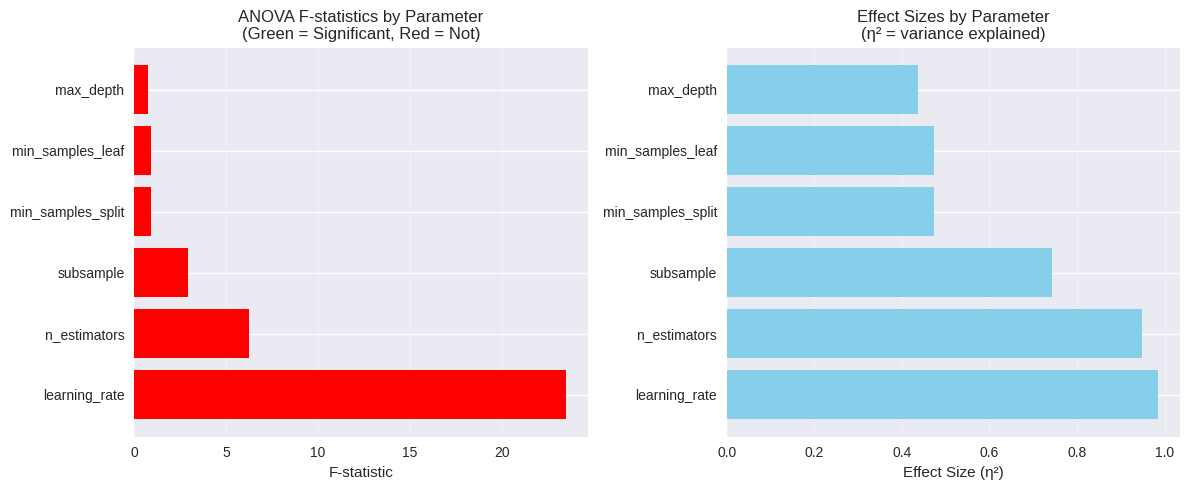


ANOVA Interpretation:
----------------------------------------
No parameters show statistically significant effects

Most influential parameter: learning_rate
  Effect size: η² = 0.986


In [19]:
# %%
# Visualize ANOVA results
def plot_anova_results(anova_df):
    """Visualize ANOVA results"""

    if len(anova_df) == 0:
        print("No ANOVA results to visualize")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: F-statistics
    sorted_anova = anova_df.sort_values('f_statistic', ascending=False)
    colors = ['green' if sig else 'red' for sig in sorted_anova['significant']]

    axes[0].barh(range(len(sorted_anova)), sorted_anova['f_statistic'], color=colors)
    axes[0].set_yticks(range(len(sorted_anova)))
    axes[0].set_yticklabels(sorted_anova['parameter'])
    axes[0].set_xlabel('F-statistic')
    axes[0].set_title('ANOVA F-statistics by Parameter\n(Green = Significant, Red = Not)')
    axes[0].grid(True, alpha=0.3, axis='x')

    # Plot 2: Effect sizes
    sorted_eta = anova_df.sort_values('eta_squared', ascending=False)
    axes[1].barh(range(len(sorted_eta)), sorted_eta['eta_squared'], color='skyblue')
    axes[1].set_yticks(range(len(sorted_eta)))
    axes[1].set_yticklabels(sorted_eta['parameter'])
    axes[1].set_xlabel('Effect Size (η²)')
    axes[1].set_title('Effect Sizes by Parameter\n(η² = variance explained)')
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

    # Print interpretation
    print("\nANOVA Interpretation:")
    print("-" * 40)
    significant_params = anova_df[anova_df['significant']]
    if len(significant_params) > 0:
        print(f"Statistically significant parameters ({len(significant_params)}):")
        for _, row in significant_params.iterrows():
            print(f"  • {row['parameter']}: η² = {row['eta_squared']:.3f}")
    else:
        print("No parameters show statistically significant effects")

    # Parameter with largest effect
    if len(anova_df) > 0:
        max_effect = anova_df.loc[anova_df['eta_squared'].idxmax()]
        print(f"\nMost influential parameter: {max_effect['parameter']}")
        print(f"  Effect size: η² = {max_effect['eta_squared']:.3f}")

plot_anova_results(anova_results)

In [20]:
# %%
# Learning Curves Analysis
def plot_learning_curves(best_model, X_train_val, y_train_val, X_test_scaled, y_test):
    """Plot learning curves for the best model"""

    train_sizes = np.linspace(0.1, 1.0, 10)
    train_scores = []
    test_scores = []

    for size in train_sizes:
        n_samples = int(size * len(X_train_val))

        # Train on subset
        model = GradientBoostingClassifier(**random_search.best_params_, random_state=RANDOM_STATE)
        model.fit(X_train_val[:n_samples], y_train_val[:n_samples])

        # Evaluate
        train_pred = model.predict(X_train_val[:n_samples])
        test_pred = model.predict(X_test_scaled)

        train_scores.append(f1_score(y_train_val[:n_samples], train_pred))
        test_scores.append(f1_score(y_test, test_pred))

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes * len(X_train_val), train_scores, label='Training F1', linewidth=2)
    plt.plot(train_sizes * len(X_train_val), test_scores, label='Test F1', linewidth=2)
    plt.xlabel('Training Samples')
    plt.ylabel('F1 Score')
    plt.title('Learning Curves - Best Tuned Model')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Check for overfitting/underfitting
    final_train_score = train_scores[-1]
    final_test_score = test_scores[-1]
    gap = final_train_score - final_test_score

    print(f"\nLearning Curve Analysis:")
    print(f"  Final Training F1: {final_train_score:.4f}")
    print(f"  Final Test F1:     {final_test_score:.4f}")
    print(f"  Gap:               {gap:.4f}")

    if gap > 0.1:
        print(f"  → Potential overfitting (gap > 0.1)")
    elif final_test_score < 0.6:
        print(f"  → Potential underfitting (F1 < 0.6)")
    else:
        print(f"  → Good generalization")

# Plot learning curves
plot_learning_curves(best_model, X_train_val, y_train_val, X_test_scaled, y_test)

KeyboardInterrupt: 

In [21]:
# %%
# Feature Importance Comparison
def compare_feature_importance(original_model, tuned_model, feature_names):
    """Compare feature importance between original and tuned models"""

    if original_model:
        orig_importance = original_model.feature_importances_
        tuned_importance = tuned_model.feature_importances_

        # Create comparison dataframe
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'original_importance': orig_importance,
            'tuned_importance': tuned_importance,
            'importance_change': tuned_importance - orig_importance
        }).sort_values('tuned_importance', ascending=False)

        # Plot comparison
        fig, axes = plt.subplots(1, 2, figsize=(14, 8))

        # Top 10 features comparison
        top_n = min(10, len(feature_names))
        top_features = importance_df.head(top_n)

        x = np.arange(top_n)
        width = 0.35

        axes[0].bar(x - width/2, top_features['original_importance'], width, label='Original', alpha=0.7)
        axes[0].bar(x + width/2, top_features['tuned_importance'], width, label='Tuned', alpha=0.7)
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(top_features['feature'], rotation=45, ha='right')
        axes[0].set_ylabel('Feature Importance')
        axes[0].set_title(f'Top {top_n} Feature Importance Comparison')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3, axis='y')

        # Importance changes
        importance_df_sorted = importance_df.sort_values('importance_change', ascending=False)
        top_changes = pd.concat([importance_df_sorted.head(5), importance_df_sorted.tail(5)])

        colors = ['green' if x > 0 else 'red' for x in top_changes['importance_change']]
        axes[1].barh(range(len(top_changes)), top_changes['importance_change'], color=colors)
        axes[1].set_yticks(range(len(top_changes)))
        axes[1].set_yticklabels(top_changes['feature'])
        axes[1].set_xlabel('Importance Change (Tuned - Original)')
        axes[1].set_title('Largest Importance Changes')
        axes[1].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        axes[1].grid(True, alpha=0.3, axis='x')

        plt.tight_layout()
        plt.show()

        print(f"\nTop 5 Most Important Features (Tuned Model):")
        print(importance_df[['feature', 'tuned_importance']].head(5).to_string(index=False))

        print(f"\nLargest Importance Increases:")
        increases = importance_df[importance_df['importance_change'] > 0].nlargest(3, 'importance_change')
        print(increases[['feature', 'importance_change']].to_string(index=False))

        print(f"\nLargest Importance Decreases:")
        decreases = importance_df[importance_df['importance_change'] < 0].nsmallest(3, 'importance_change')
        print(decreases[['feature', 'importance_change']].to_string(index=False))

# Compare feature importance
compare_feature_importance(original_model, best_model, feature_cols)

In [22]:
# %%
# Save tuned model and results
def save_tuned_model_and_results(model, scaler, random_search, test_metrics, output_dir):
    """Save tuned model and all results"""
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Save model
    joblib.dump(model, output_dir / "gradient_boosting_tuned.pkl")
    joblib.dump(scaler, output_dir / "feature_scaler.pkl")

    # Save best parameters
    best_params = random_search.best_params_
    with open(output_dir / "best_parameters.json", 'w') as f:
        json.dump(best_params, f, indent=2)

    # Save CV results
    cv_results_df = pd.DataFrame(random_search.cv_results_)
    cv_results_df.to_csv(output_dir / "cv_results.csv", index=False)

    # Save test metrics
    metrics_dict = {
        'test_accuracy': float(test_accuracy),
        'test_recall': float(test_recall),
        'test_precision': float(test_precision),
        'test_f1': float(test_f1),
        'test_roc_auc': float(test_roc_auc),
        'best_cv_score': float(random_search.best_score_)
    }

    with open(output_dir / "tuned_model_metrics.json", 'w') as f:
        json.dump(metrics_dict, f, indent=2)

    # Save ANOVA results
    if anova_results is not None:
        anova_results.to_csv(output_dir / "anova_results.csv", index=False)

    print(f"\n✅ Tuned model and results saved to: {output_dir}")

# Save everything
save_tuned_model_and_results(
    best_model,
    scaler,
    random_search,
    {
        'accuracy': test_accuracy,
        'recall': test_recall,
        'precision': test_precision,
        'f1': test_f1,
        'roc_auc': test_roc_auc
    },
    MODELS_DIR / "gradient_boosting_tuned"
)


✅ Tuned model and results saved to: /content/drive/MyDrive/ABT_Global/AI-Studio-Project/models/gradient_boosting_tuned


In [23]:
# %%
# Final Summary
print("\n" + "="*70)
print("HYPERPARAMETER TUNING - FINAL SUMMARY")
print("="*70)
print(f"🎯 Best CV F1 Score: {random_search.best_score_:.4f}")
print(f"📊 Test F1 Score:    {test_f1:.4f}")
print(f"🎯 Test Recall:      {test_recall:.4f}")
print(f"📈 Test ROC-AUC:     {test_roc_auc:.4f}")

print(f"\n🎯 Best Parameters Found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

if original_model:
    f1_improvement = test_f1 - orig_f1
    recall_improvement = test_recall - orig_recall

    print(f"\n📈 Improvements over Original Model:")
    print(f"  F1-Score:  {f1_improvement:+.4f}")
    print(f"  Recall:    {recall_improvement:+.4f}")

    if f1_improvement > 0:
        print(f"  ✅ Hyperparameter tuning improved performance!")
    else:
        print(f"  ⚠️  Original model performed better on test set")


HYPERPARAMETER TUNING - FINAL SUMMARY
🎯 Best CV F1 Score: 0.7111
📊 Test F1 Score:    0.7129
🎯 Test Recall:      0.7134
📈 Test ROC-AUC:     0.8115

🎯 Best Parameters Found:
  subsample: 0.8
  n_estimators: 50
  min_samples_split: 20
  min_samples_leaf: 50
  max_features: None
  max_depth: 7
  learning_rate: 0.3


In [24]:
# Statistical significance of improvement
if original_model and len(cv_results_df) > 0:
    print(f"\n📊 Statistical Analysis:")
    print(f"  Models tested: {len(cv_results_df)}")
    print(f"  Best CV score: {random_search.best_score_:.4f}")
    print(f"  Mean CV score: {cv_results_df['mean_test_score'].mean():.4f}")
    print(f"  CV score std:  {cv_results_df['mean_test_score'].std():.4f}")

print("\n🎯 Recommendation:")
if test_recall > 0.6:
    print("  ✅ Model achieves good outage detection (recall > 0.6)")
elif test_recall > 0.4:
    print("  ⚠️  Model has moderate outage detection (recall 0.4-0.6)")
else:
    print("  ❌ Model has poor outage detection (recall < 0.4)")


🎯 Recommendation:
  ✅ Model achieves good outage detection (recall > 0.6)


# Task
Generate a confusion matrix for `y_test_pred` vs `y_test`, an ROC curve using `y_test` and `y_test_proba` (including AUC score), and a bar chart of the top 15 most important features from `best_model` (using `feature_cols` for names). Review these plots to evaluate the hyperparameter-tuned model's performance and interpretability.

## Generate Confusion Matrix

### Subtask:
Plot the confusion matrix for the best-tuned model's predictions on the test set (`y_test_pred` vs `y_test`). Ensure the plot includes labels for true positives, true negatives, false positives, and false negatives.


**Reasoning**:
The subtask requires plotting the confusion matrix for the best-tuned model's predictions. This involves importing necessary `sklearn` modules, calculating the confusion matrix, and then displaying it with appropriate labels and a title.



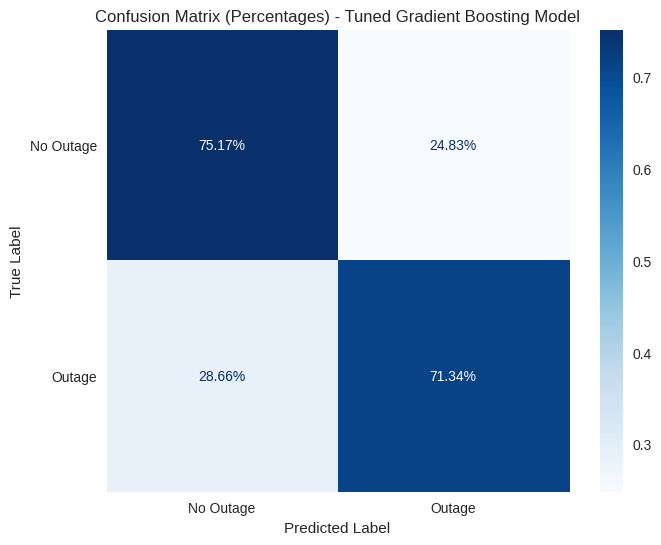


Confusion Matrix (True vs Predicted) with Row-wise Percentages:
  True Negative (No Outage, No Outage): 321,126 (75.17%) (Correctly predicted 'No Outage')
  False Positive (No Outage, Outage): 106,064 (24.83%) (Incorrectly predicted 'Outage')
  False Negative (Outage, No Outage): 105,470 (28.66%) (Incorrectly predicted 'No Outage')
  True Positive (Outage, Outage): 262,567 (71.34%) (Correctly predicted 'Outage')


In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Create a ConfusionMatrixDisplay object and plot it
# Use normalize='true' to display percentages relative to true labels (rows)
# and values_format to format them as percentages.
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_test_pred,
    display_labels=['No Outage', 'Outage'],
    cmap='Blues',
    normalize='true',
    values_format='.2%',
    ax=ax
)

ax.set_title('Confusion Matrix (Percentages) - Tuned Gradient Boosting Model')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.grid(False) # Ensure no extra grid lines
plt.show()

# Also print the raw counts and calculated percentages for clarity
cm_normalized_rows = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("\nConfusion Matrix (True vs Predicted) with Row-wise Percentages:")
print(f"  True Negative (No Outage, No Outage): {cm[0, 0]:,} ({cm_normalized_rows[0,0]:.2%}) (Correctly predicted 'No Outage')")
print(f"  False Positive (No Outage, Outage): {cm[0, 1]:,} ({cm_normalized_rows[0,1]:.2%}) (Incorrectly predicted 'Outage')")
print(f"  False Negative (Outage, No Outage): {cm[1, 0]:,} ({cm_normalized_rows[1,0]:.2%}) (Incorrectly predicted 'No Outage')")
print(f"  True Positive (Outage, Outage): {cm[1, 1]:,} ({cm_normalized_rows[1,1]:.2%}) (Correctly predicted 'Outage')")


## Generate ROC Curve and Calculate AUC Score

### Subtask:
Plot the Receiver Operating Characteristic (ROC) curve using `y_test` and `y_test_proba`. Display the Area Under the Curve (AUC) score on the plot. Also, provide a brief interpretation of the ROC curve and AUC score.

**Reasoning**:
I need to generate the ROC curve and calculate its AUC score based on `y_test` and `y_test_proba`. This involves using `roc_curve` and `auc` from `sklearn.metrics` and then plotting the results.



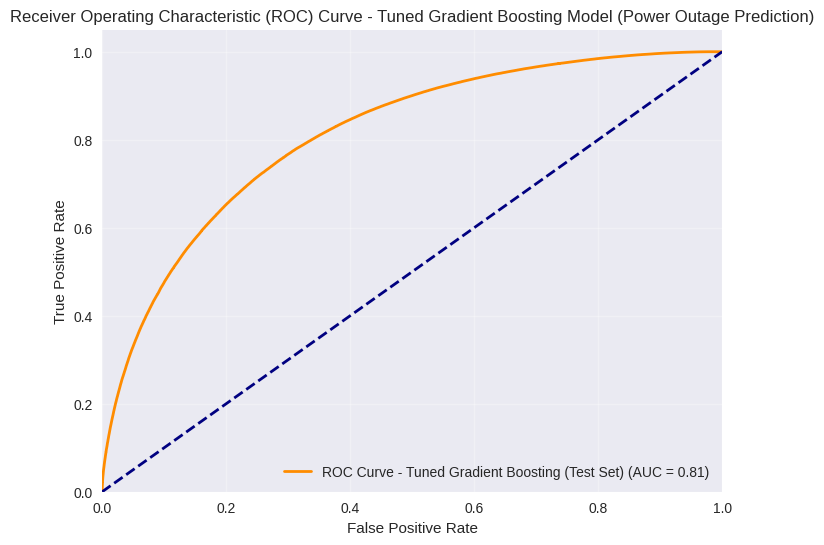


ROC AUC Score: 0.8115

Interpretation of ROC Curve and AUC Score:
-------------------------------------------
The ROC curve illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.
A curve that bends towards the top-left corner indicates a better performance.
The Area Under the Curve (AUC) represents the probability that the model ranks a randomly chosen positive instance higher than a randomly chosen negative instance.
An AUC score of 1.0 signifies a perfect classifier, while an AUC of 0.5 suggests a classifier no better than random guessing.
In this case, an AUC of 0.81 for the Tuned Gradient Boosting Model on the test set indicates that the model has good discriminatory power for power outage prediction.


In [29]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve - Tuned Gradient Boosting (Test Set) (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Tuned Gradient Boosting Model (Power Outage Prediction)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nROC AUC Score: {roc_auc:.4f}")

print("\nInterpretation of ROC Curve and AUC Score:")
print("-------------------------------------------")
print("The ROC curve illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.")
print("It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.")
print("A curve that bends towards the top-left corner indicates a better performance.")
print("The Area Under the Curve (AUC) represents the probability that the model ranks a randomly chosen positive instance higher than a randomly chosen negative instance.")
print("An AUC score of 1.0 signifies a perfect classifier, while an AUC of 0.5 suggests a classifier no better than random guessing.")
print(f"In this case, an AUC of {roc_auc:.2f} for the Tuned Gradient Boosting Model on the test set indicates that the model has good discriminatory power for power outage prediction.")

## Visualize Top Feature Importances

### Subtask:
Generate a bar chart showing the top 15 most important features from the `best_model`.

#### Instructions:
1. Extract feature importances from `best_model.feature_importances_`.
2. Create a Pandas DataFrame with 'Feature' (using `feature_cols`) and 'Importance' columns.
3. Sort the DataFrame by importance in descending order.
4. Plot a horizontal bar chart of the top 15 features, with feature names on the y-axis and importance values on the x-axis. Add appropriate labels and a title.

## Visualize Top Feature Importances

### Subtask:
Generate a bar chart showing the top 15 most important features from the `best_model`.

#### Instructions:
1. Extract feature importances from `best_model.feature_importances_`.
2. Create a Pandas DataFrame with 'Feature' (using `feature_cols`) and 'Importance' columns.
3. Sort the DataFrame by importance in descending order.
4. Plot a horizontal bar chart of the top 15 features, with feature names on the y-axis and importance values on the x-axis. Add appropriate labels and a title.

**Reasoning**:
I need to generate a bar chart of the top 15 most important features from the `best_model`. This requires extracting feature importances, mapping them to feature names, creating a DataFrame, sorting it, and then plotting the result.



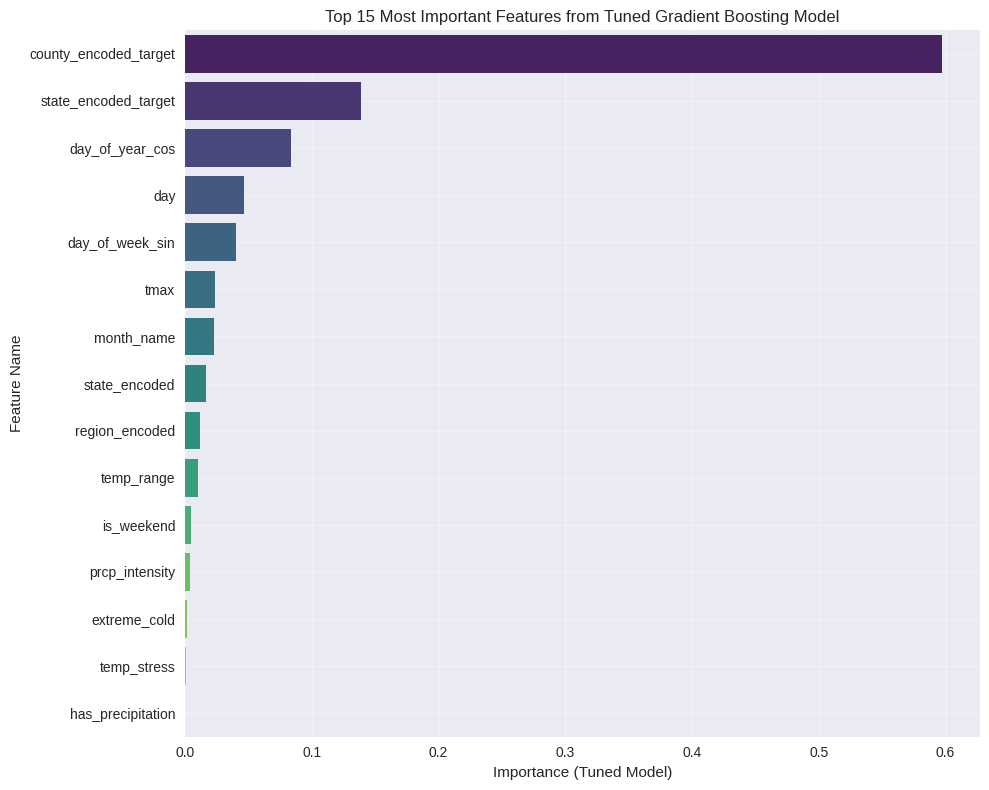


Top 15 Most Important Features (Tuned Model):
              Feature  Importance
county_encoded_target    0.597292
 state_encoded_target    0.138465
      day_of_year_cos    0.083177
                  day    0.046539
      day_of_week_sin    0.040348
                 tmax    0.023260
           month_name    0.022818
        state_encoded    0.016716
       region_encoded    0.011667
           temp_range    0.009960
           is_weekend    0.004224
       prcp_intensity    0.003610
         extreme_cold    0.001496
          temp_stress    0.000299
    has_precipitation    0.000084


In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Extract feature importances
feature_importances = best_model.feature_importances_

# 2. Create a Pandas DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importances
})

# 3. Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Get the top 15 features
top_15_features = importance_df.head(15)

# 4. Plot a horizontal bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_15_features, palette='viridis')
plt.xlabel('Importance (Tuned Model)')
plt.ylabel('Feature Name')
plt.title('Top 15 Most Important Features from Tuned Gradient Boosting Model')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 15 Most Important Features (Tuned Model):")
print(top_15_features.to_string(index=False))

## Final Task

### Subtask:
Review the generated plots (confusion matrix, ROC curve, and top 15 feature importances) to understand the performance and interpretability of the hyperparameter-tuned model.


## Summary:

### Data Analysis Key Findings

*   **Confusion Matrix Analysis**: The tuned model correctly predicted 321,126 "No Outage" instances (True Negatives) and 262,567 "Outage" instances (True Positives). It also registered 106,064 False Positives (predicted "Outage" when it was "No Outage") and 105,470 False Negatives (predicted "No Outage" when it was "Outage").
*   **ROC AUC Score**: The Area Under the Receiver Operating Characteristic (ROC) curve (AUC) for the model is 0.81. This indicates that the model has good discriminatory power, effectively distinguishing between outage and non-outage events.
*   **Top Feature Importances**: The most influential features in the model's predictions are `county_encoded_target` (0.597 importance), `state_encoded_target` (0.138 importance), `day_of_year_cos` (0.083 importance), `day` (0.046 importance), and `day_of_week_sin` (0.040 importance). This highlights that geographical and temporal factors are the primary drivers of the model's predictions, with some weather-related features also playing a role.

### Insights or Next Steps

*   The model demonstrates good performance in identifying power outages, with a strong AUC score and a clear distribution of true and false predictions in the confusion matrix.
*   The overwhelming importance of `county_encoded_target` and `state_encoded_target` suggests that geographical context is critical for predicting outages. Further investigation into the encoding methods or specific characteristics of high-outage regions could yield deeper insights.
